## Changes occuring in pulse oximetry related to COVID-19: 01/2019-01/2021

Below are various time-series charts showing changes in total nationwide use of pulse oximetry related to COVID-19 as well as a breakdown by region and other demographic variables.  The following charts are available:

* [Total pulse oximetry use](#total)
* [Pulse oximetry use by region](#region)
* [Pulse oximetry use by age group](#age)
* [Pulse oximetry use by sex](#sex)

### Methods

Using OpenSAFELY-TPP, covering 40% of England's population, we have assessed coding activity related to pulse oximetry related to COVID-19 in general practice from the beginning of January 2019 until the end of Januray 2021.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os






measures_df_sex = pd.read_csv('output/measures/measure_pulse_ox_by_sex.csv')
measures_df_region = pd.read_csv(
    'output/measures/measure_pulse_ox_by_region.csv')
measures_df_age = pd.read_csv(
    'output/measures/measure_pulse_ox_by_age_band.csv')
measures_df_total = pd.read_csv(
    'output/measures/measure_pulse_ox_total.csv')


#temporary fix for population not working in Measures
measures_df_total = measures_df_total.groupby(
    ['date'])['had_pulse_ox', 'population'].sum().reset_index()
measures_df_total['value'] = measures_df_total['had_pulse_ox'] / \
    measures_df_total['population']


def to_datetime_sort(df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date')


to_datetime_sort(measures_df_sex)
to_datetime_sort(measures_df_region)
to_datetime_sort(measures_df_age)
to_datetime_sort(measures_df_total)


def calculate_rate(df, value_col='had_pulse_ox', population_col='population'):
    num_per_hundred_thousand = df[value_col]/(df[population_col]/100000)
    df['num_per_hundred_thousand'] = num_per_hundred_thousand


calculate_rate(measures_df_sex)
calculate_rate(measures_df_age)
calculate_rate(measures_df_region)
calculate_rate(measures_df_total)


def plot_measures(df, title, filename, column_to_plot, category=False, y_label='Number per 100, 000'):

    if category:
        for unique_category in df[category].unique():

            df_subset = df[df[category] == unique_category]

            plt.plot(df_subset['date'], df_subset[column_to_plot])
    else:
        plt.plot(df['date'], df[column_to_plot])

    plt.ylabel(y_label)
    plt.xlabel('Date')
    plt.xticks(rotation='vertical')
    plt.title(title)

    if category:
        plt.legend(df[category].unique(), bbox_to_anchor=(
            1.04, 1), loc="upper left")

    else:
        pass

    plt.savefig(f'output/figures/{filename}.jpeg', bbox_inches='tight')
   
    plt.clf()


plot_measures(measures_df_total, 'Pulse Oximetry use across Whole Population',
              'population_rates', 'had_pulse_ox', category=False, y_label='Total Number')

plot_measures(measures_df_sex,
              'Pulse Oximetry use by Sex per 100, 000', 'sex_rates', 'num_per_hundred_thousand', category='sex', )
plot_measures(measures_df_region,
              'Pulse Oximetry use by Region per 100, 000', 'region_rates', 'num_per_hundred_thousand', category='region')
plot_measures(measures_df_age,
              'Pulse Oximetry use by Age Band per 100, 000',  'age_rates', 'num_per_hundred_thousand', category='age_band')


In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from collections import Counter

In [43]:
measures_df_hosp_adm = pd.DataFrame(columns=["hospital_admission", "recent_admission", "population", "value", "date"])

def generate_smr_hosp_column(row):
  
    if row['had_smr'] == 1:
        #were they given hospitalised in months previous
        if row['hospital_admission']is pd.NaT:
            hospitalised_prev_months = 0
        
        else:
            #They were hospitalised but was it in months previous?
            smr_date = row['had_smr_date']
            hospital_admission_date = row['hospital_admission']
            
            hospital_admission_prev_months = smr_date + relativedelta(months=-3)
            mask = (hospital_admission_date < smr_date) & (hospital_admission_date > hospital_admission_prev_months)
            
            if mask:
                hospitalised_prev_months = 1
            else:
                hospitalised_prev_months = 0
    else:
        hospitalised_prev_months = 'nan'
        
    return hospitalised_prev_months

      
dataframes = []
input_root = '../output/measures/smr'
for file in os.listdir(input_root):
    if file.startswith('input_smr'):
        date=file.split('_')[-1][:-4]
        df = pd.read_csv(input_root + '/' + file)
        
        df['hospital_admission'] = pd.to_datetime(df['hospital_admission'], format='%Y-%m-%d')
        df['had_smr_date'] = pd.to_datetime(df['had_smr_date'], format='%Y-%m-%d')
        
     
       
        df['hospitalised_prev_months'] = df.apply(generate_smr_hosp_column, axis=1)
        
        df_smr = df[df['had_smr'] == 1]
        df_no_smr = df[df['had_smr'] == 0]
        
        
        population_admitted = sum(df_smr['hospital_admission'].notnull()) + sum(df_no_smr['hospital_admission'].notnull())
        population_not_admitted = sum(df_smr['hospital_admission'].isnull()) + sum(df_no_smr['hospital_admission'].isnull())
        
        had_smr_admitted = sum(df_smr['hospital_admission'].notnull())
        had_smr_not_admitted = sum(df_smr['hospital_admission'].isnull())
   
        measures_df_hosp_adm.loc[measures_df_hosp_adm.shape[0]] = 1, had_smr_admitted, population_admitted, had_smr_admitted/population_admitted, date
        measures_df_hosp_adm.loc[measures_df_hosp_adm.shape[0]] = 0, had_smr_not_admitted, population_not_admitted, had_smr_not_admitted/population_not_admitted, date
   


In [44]:
measures_df_hosp_adm.head()

,hospital_admission,recent_admission,population,value,date
0,1,390,2000,0.19500,2021-01-01
1,0,1610,8000,0.20125,2021-01-01
2,1,398,2000,0.19900,2019-01-01
3,0,1602,8000,0.20025,2019-01-01
4,1,394,2000,0.19700,2020-07-01


In [45]:
def to_datetime_sort(df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    
to_datetime_sort(measures_df_hosp_adm)

In [46]:
measures_df_hosp_adm.head()

,hospital_admission,recent_admission,population,value,date
2,1,398,2000,0.199000,2019-01-01
3,0,1602,8000,0.200250,2019-01-01
39,0,1613,8000,0.201625,2019-02-01
38,1,387,2000,0.193500,2019-02-01
11,0,1615,8000,0.201875,2019-03-01


In [47]:
def calculate_rate(df, value_col='had_smr', population_col='population'):
    num_per_hundred_thousand = df[value_col]/(df[population_col]/100000)
    df['num_per_hundred_thousand'] = num_per_hundred_thousand
    
calculate_rate(measures_df_hosp_adm, value_col='recent_admission')

In [48]:
to_datetime_sort(measures_df_hosp_adm)
measures_df_hosp_adm

,hospital_admission,recent_admission,population,value,date,num_per_hundred_thousand
2,1,398,2000,0.199000,2019-01-01,19900
3,0,1602,8000,0.200250,2019-01-01,20025
39,0,1613,8000,0.201625,2019-02-01,20162.5
38,1,387,2000,0.193500,2019-02-01,19350
11,0,1615,8000,0.201875,2019-03-01,20187.5
10,1,385,2000,0.192500,2019-03-01,19250
51,0,1598,8000,0.199750,2019-04-01,19975
50,1,402,2000,0.201000,2019-04-01,20100
23,0,1604,8000,0.200500,2019-05-01,20050
22,1,396,2000,0.198000,2019-05-01,19800


In [20]:
measures_df_sex = pd.read_csv('../output/measures/measure_pulse_ox_by_sex.csv')
measures_df_region = pd.read_csv('../output/measures/measure_pulse_ox_by_region.csv')
measures_df_age = pd.read_csv('../output/measures/measure_pulse_ox_by_age_band.csv')
measures_df_total = pd.read_csv('../output/measures/measure_pulse_ox_total.csv')

measures_df_total = measures_df_total.groupby(['date']) ['had_pulse_ox', 'population'].sum().reset_index()
measures_df_total['value'] = measures_df_total['had_pulse_ox']/measures_df_total['population']

FileNotFoundError: [Errno 2] File b'../output/measures/measure_smr_by_sex.csv' does not exist: b'../output/measures/measure_smr_by_sex.csv'

In [9]:
def to_datetime_sort(df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date')
    
to_datetime_sort(measures_df_sex)
to_datetime_sort(measures_df_region)
to_datetime_sort(measures_df_age)
to_datetime_sort(measures_df_total)

In [12]:
def calculate_rate(df, value_col='had_pulse_ox', population_col='population'):
    num_per_hundred_thousand = df[value_col]/(df[population_col]/100000)
    df['num_per_hundred_thousand'] = num_per_hundred_thousand
    
calculate_rate(measures_df_sex)
calculate_rate(measures_df_age)
calculate_rate(measures_df_region)
calculate_rate(measures_df_total)

In [10]:
def plot_measures(df, title, filename, column_to_plot, category=False, y_label='Number per 100, 000'):

    if category:
        for unique_category in df[category].unique():

            df_subset = df[df[category] == unique_category]

            plt.plot(df_subset['date'], df_subset[column_to_plot])
    else:
        plt.plot(df['date'], df[column_to_plot])

    plt.ylabel(y_label)
    plt.xlabel('Date')
    plt.xticks(rotation='vertical')
    plt.title(title)

    if category:
        plt.legend(df[category].unique(), bbox_to_anchor=(
            1.04, 1), loc="upper left")

    else:
        pass

    plt.savefig(f'../output/figures/{filename}.jpeg', bbox_inches='tight')
    plt.show()
    plt.clf()


plot_measures(measures_df_total, 'Pulse Oximetry use across Whole Population', 
              'population_rates', 'had_pulse_ox', category=False, y_label='Total Number')

plot_measures(measures_df_sex,
              'Pulse Oximetry use by Sex per 100, 000', 'sex_rates', 'num_per_hundred_thousand', category='sex', )
plot_measures(measures_df_region,
              'Pulse Oximetry use by Region per 100, 000', 'region_rates', 'num_per_hundred_thousand', category='region')
plot_measures(measures_df_age,
              'Pulse Oximetry use by Age Band per 100, 000',  'age_rates', 'num_per_hundred_thousand', category='age_band')




NameError: name 'measures_df_total' is not defined

/Users/Louis/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


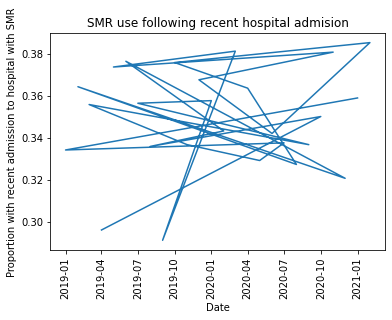

<Figure size 432x288 with 0 Axes>

In [11]:
plot_measures(measures_df_hosp_adm,
              'SMR use following recent hospital admision',  'hosp_adm_rates', 'value', category=False, y_label="Proportion with recent admission to hospital with SMR")

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os


if not os.path.exists('../output/figures'):
    os.mkdir('../output/figures')


if not os.path.exists('../output/figures/smr'):
    os.mkdir('../output/figures/smr')


measures_df_hosp_adm = pd.DataFrame(columns=[
                                    "hospital_admission", "recent_admission", "population", "value", "date"])


def generate_smr_hosp_column(row):

    if row['had_smr'] == 1:
        #were they given hospitalised in months previous
        if row['hospital_admission'] is pd.NaT:
            hospitalised_prev_months = 0

        else:
            #They were hospitalised but was it in months previous?
            smr_date = row['had_smr_date']
            hospital_admission_date = row['hospital_admission']

            hospital_admission_prev_months = smr_date + \
                relativedelta(months=-3)
            mask = (hospital_admission_date < smr_date) & (
                hospital_admission_date > hospital_admission_prev_months)

            if mask:
                hospitalised_prev_months = 1
            else:
                hospitalised_prev_months = 0
    else:
        hospitalised_prev_months = 'nan'

    return hospitalised_prev_months


dataframes = []
input_root = '../output/measures/smr'
for file in os.listdir(input_root):
    if file.startswith('input_smr'):
        date = file.split('_')[-1][:-4]
        df = pd.read_csv(input_root + '/' + file)

        df['hospital_admission'] = pd.to_datetime(
            df['hospital_admission'], format='%Y-%m-%d')
        df['had_smr_date'] = pd.to_datetime(
            df['had_smr_date'], format='%Y-%m-%d')

        df['hospitalised_prev_months'] = df.apply(
            generate_smr_hosp_column, axis=1)

        df_smr = df[df['had_smr'] == 1]
        df_no_smr = df[df['had_smr'] == 0]

        population_admitted = sum(df_smr['hospital_admission'].notnull(
        )) + sum(df_no_smr['hospital_admission'].notnull())
        population_not_admitted = sum(df_smr['hospital_admission'].isnull(
        )) + sum(df_no_smr['hospital_admission'].isnull())

        had_smr_admitted = sum(df_smr['hospital_admission'].notnull())
        had_smr_not_admitted = sum(df_smr['hospital_admission'].isnull())

        measures_df_hosp_adm.loc[measures_df_hosp_adm.shape[0]
                                 ] = 1, had_smr_admitted, population_admitted, had_smr_admitted/population_admitted, date
        measures_df_hosp_adm.loc[measures_df_hosp_adm.shape[0]
                                 ] = 0, had_smr_not_admitted, population_not_admitted, had_smr_not_admitted/population_not_admitted, date







measures_df_sex = pd.read_csv('../output/measures/smr/measure_smr_by_sex.csv')
measures_df_region = pd.read_csv(
    '../output/measures/smr/measure_smr_by_region.csv')
measures_df_age = pd.read_csv(
    '../output/measures/smr/measure_smr_by_age_band.csv')
measures_df_falls = pd.read_csv(
    '../output/measures/smr/measure_smr_by_falls.csv')
measures_df_care_home_status = pd.read_csv(
    '../output/measures/smr/measure_smr_by_care_home_status.csv')
measures_df_total = pd.read_csv(
    '../output/measures/smr/measure_smr_total.csv')


#temporary fix for population not working in Measures
measures_df_total = measures_df_total.groupby(
    ['date'])['had_smr', 'population'].sum().reset_index()
measures_df_total['value'] = measures_df_total['had_smr'] / \
    measures_df_total['population']


def to_datetime_sort(df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)


to_datetime_sort(measures_df_sex)
to_datetime_sort(measures_df_region)
to_datetime_sort(measures_df_age)
to_datetime_sort(measures_df_total)
to_datetime_sort(measures_df_hosp_adm)
to_datetime_sort(measures_df_falls)
to_datetime_sort(measures_df_care_home_status)


def calculate_rate(df, value_col='had_smr', population_col='population'):
    num_per_hundred_thousand = df[value_col]/(df[population_col]/100000)
    df['num_per_hundred_thousand'] = num_per_hundred_thousand


calculate_rate(measures_df_sex)
calculate_rate(measures_df_age)
calculate_rate(measures_df_region)
calculate_rate(measures_df_total)
calculate_rate(measures_df_hosp_adm, value_col='recent_admission')
calculate_rate(measures_df_falls)
calculate_rate(measures_df_care_home_status)


def plot_measures(df, title, filename, column_to_plot, category=False, y_label='Number per 100, 000'):

    if category:
        for unique_category in df[category].unique():

            df_subset = df[df[category] == unique_category]

            plt.plot(df_subset['date'], df_subset[column_to_plot])
    else:
        plt.plot(df['date'], df[column_to_plot])

    plt.ylabel(y_label)
    plt.xlabel('Date')
    plt.xticks(rotation='vertical')
    plt.title(title)

    if category:
        plt.legend(df[category].unique(), bbox_to_anchor=(
            1.04, 1), loc="upper left")

    else:
        pass

    plt.savefig(f'../output/figures/smr/{filename}.jpeg', bbox_inches='tight')

    plt.clf()


plot_measures(measures_df_total, 'SMR use across Whole Population',
              'population_rates', 'had_smr', category=False, y_label='Total Number')

plot_measures(measures_df_sex,
              'SMR use by Sex per 100, 000', 'sex_rates', 'num_per_hundred_thousand', category='sex', )
plot_measures(measures_df_region,
              'SMR use by Region per 100, 000', 'region_rates', 'num_per_hundred_thousand', category='region')
plot_measures(measures_df_age,
              'SMR use by Age Band per 100, 000',  'age_rates', 'num_per_hundred_thousand', category='age_band')
plot_measures(measures_df_hosp_adm,
              'SMR use following recent hospital admision',  'hosp_adm_rates', 'num_per_hundred_thousand', category='hospital_admission')

plot_measures(measures_df_care_home_status,
              'SMR use by care home status per 100, 000',  'care_home_status_rates', 'num_per_hundred_thousand', category='care_home_status')
plot_measures(measures_df_falls,
              'SMR use by fall status per 100, 000',  'falls_rates', 'num_per_hundred_thousand', category='falls')


/Users/Louis/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

In [52]:
measures_df_hosp_adm.head()

,hospital_admission,recent_admission,population,value,date,num_per_hundred_thousand
2,1,398,2000,0.199000,2019-01-01,19900
3,0,1602,8000,0.200250,2019-01-01,20025
39,0,1613,8000,0.201625,2019-02-01,20162.5
38,1,387,2000,0.193500,2019-02-01,19350
11,0,1615,8000,0.201875,2019-03-01,20187.5


In [53]:
measures_df_falls.head()

,falls,had_smr,population,value,date,num_per_hundred_thousand
0,0,1615.0,8000,0.201875,2019-01-01,20187.5
1,1,385.0,2000,0.192500,2019-01-01,19250.0
2,0,1592.0,8000,0.199000,2019-02-01,19900.0
3,1,408.0,2000,0.204000,2019-02-01,20400.0
4,0,1616.0,8000,0.202000,2019-03-01,20200.0


In [12]:
# Import functions
from cohortextractor import (
    StudyDefinition, 
    patients, 
    codelist,
   
    codelist_from_csv
)

import pandas as pd

codelist_df = pd.read_csv("../codelists/opensafely-pulse-oximetry.csv")

pulse_ox_code_mapping = {"1325251000000106": "Y2a44",
                         "1325261000000109": "Y2a45",
                         "1325271000000102": "Y2a46",
                         "1325201000000105": "Y2a47",
                         "1325191000000108": "Y2a48", 
                         "1325221000000101": "Y2a49",
                         "1325241000000108": "Y2a4a",
                         "1325281000000100": "Y2a4b",
                         "1325681000000102": "Y2b97",
                         "1325701000000100": "Y2b98",
                         "1325691000000100": "Y2b99",
                         "1325211000000107": "YA796"
                         }

def apply_code_mapping(row):
    row['CTV3ID'] = pulse_ox_code_mapping[str(row['code'])]
    return row

codelist_df = codelist_df.apply(lambda row: apply_code_mapping(row), axis=1)

codelist_df.to_csv("../codelists/opensafely-pulse-oximetry.csv")


pulse_oximetry_codes = codelist_from_csv("../codelists/opensafely-pulse-oximetry.csv",
    system="snomed",
    column="code",)




In [6]:
pulse_oximetry_codes

['1325191000000108',
 '1325201000000105',
 '1325211000000107',
 '1325221000000101',
 '1325241000000108',
 '1325251000000106',
 '1325261000000109',
 '1325271000000102',
 '1325281000000100',
 '1325681000000102',
 '1325691000000100',
 '1325701000000100']